In [1]:
from IPython.display import Image
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# inline plotting instead of popping out
%matplotlib inline

# load utility classes/functions that has been taught in previous labs
# e.g., plot_decision_regions()
import os, sys
module_path = os.path.abspath(os.path.join('.'))
sys.path.append(module_path)
from lib import *

In [2]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

iris = load_iris()
X, y = iris.data[:, [1, 2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)
# hold out validation set
X_itrain, X_val, y_itrain, y_val = train_test_split(
    X_train, y_train, test_size=0.3, random_state=0)

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_k, best_score = -1, -1
clfs = {}

# hyperparameter tuning
for k in [1, 15, 50]:
  pipe = Pipeline([['sc', StandardScaler()],
                   ['clf', KNeighborsClassifier(n_neighbors=k)]])
  pipe.fit(X_itrain, y_itrain)
  y_pred = pipe.predict(X_val)
  score = accuracy_score(y_val, y_pred)
  print('[{}-NN]\nValidation accuracy: {}'.format(k, score))
  if score > best_score:
    best_k, best_score = k, score
  clfs[k] = pipe

clf = clfs[best_k]
clf.fit(X_train, y_train)
# performance reporting
y_pred = clf.predict(X_test)
print('\nTest accuracy: %.2f (n_neighbors=%d selected by the holdout method)' %
      (accuracy_score(y_test, y_pred), best_k))

[1-NN]
Validation accuracy: 0.9375
[15-NN]
Validation accuracy: 0.90625
[50-NN]
Validation accuracy: 0.4375

Test accuracy: 0.89 (n_neighbors=1 selected by the holdout method)


In [4]:
clf = clfs[15]
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=15 selected manually)' % accuracy_score(
    y_test, y_pred))

Test accuracy: 0.93 (n_neighbors=15 selected manually)


In [5]:
from sklearn.model_selection import cross_val_score

iris = load_iris()
X, y = iris.data[:, [1, 2]], iris.target

# hold out testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1)

In [6]:
best_k, best_score = -1, -1
clfs = {}

for k in [1, 15, 50]:  # experiment different hyperparameter
  pipe = Pipeline([['sc', StandardScaler()],
                   ['clf', KNeighborsClassifier(n_neighbors=k)]])
  pipe.fit(X_train, y_train)
  # K-Fold CV
  scores = cross_val_score(pipe, X_train, y_train, cv=5)
  print('[%d-NN]\nValidation accuracy: %.3f %s' % (k, scores.mean(), scores))
  if scores.mean() > best_score:
    best_k, best_score = k, scores.mean()
  clfs[k] = pipe

[1-NN]
Validation accuracy: 0.894 [ 0.91304348  0.95454545  0.85        0.85        0.9       ]
[15-NN]
Validation accuracy: 0.914 [ 0.95652174  0.86363636  0.85        0.9         1.        ]
[50-NN]
Validation accuracy: 0.801 [ 0.73913043  0.86363636  0.75        0.75        0.9       ]


In [7]:
best_clf = clfs[best_k]
best_clf.fit(X_train, y_train)

# performance reporting
y_pred = best_clf.predict(X_test)
print('Test accuracy: %.2f (n_neighbors=%d selected by 5-fold CV)' %
      (accuracy_score(y_test, y_pred), best_k))

Test accuracy: 0.93 (n_neighbors=15 selected by 5-fold CV)


In [8]:
from sklearn.model_selection import KFold

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
  print('[Outer fold %d/5]' % (i + 1))
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  best_k, best_score = -1, -1
  clfs = {}
  # hyperparameter tuning
  for k in [1, 15, 50]:
    inner_scores = []
    # inner folds
    for itrain_idx, val_idx in inner_cv.split(X_train, y_train):
      X_itrain, X_val = X_train[itrain_idx], X_train[val_idx]
      y_itrain, y_val = y_train[itrain_idx], y_train[val_idx]

      pipe = Pipeline([['sc', StandardScaler()],
                       ['clf', KNeighborsClassifier(n_neighbors=k)]])
      pipe.fit(X_itrain, y_itrain)

      y_pred = pipe.predict(X_val)
      inner_scores.append(accuracy_score(y_val, y_pred))
    score_mean = np.mean(inner_scores)
    if best_score < score_mean:
      best_k, best_score = k, score_mean
    clfs[k] = pipe

  # evaluate performance on test fold
  best_clf = clfs[best_k]
  best_clf.fit(X_train, y_train)
  y_pred = best_clf.predict(X_test)
  outer_scores.append(accuracy_score(y_test, y_pred))
  print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], best_k))

print('\nTest accuracy: %.2f (5x2 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x2 nested CV)


In [9]:
from sklearn.model_selection import GridSearchCV

outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
inner_cv = KFold(n_splits=10, shuffle=True, random_state=1)

outer_scores = []
# outer folds
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, y)):
  print('[Outer fold %d/5]' % (i + 1))
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  pipe = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier()]])
  # hyperparameter tuning by grid search CV
  param_grid = {'clf__n_neighbors': [1, 15, 50]}
  gs = GridSearchCV(
      estimator=pipe, param_grid=param_grid, scoring='accuracy', cv=inner_cv)
  gs.fit(X_train, y_train)
  best_clf = gs.best_estimator_
  best_clf.fit(X_train, y_train)
  outer_scores.append(best_clf.score(X_test, y_test))
  print('Test accuracy: %.2f (n_neighbors=%d selected by inner 10-fold CV)' %
        (outer_scores[i], gs.best_params_['clf__n_neighbors']))

print('\nTest accuracy: %.2f (5x10 nested CV)' % np.mean(outer_scores))

[Outer fold 1/5]
Test accuracy: 0.90 (n_neighbors=1 selected by inner 10-fold CV)
[Outer fold 2/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 3/5]
Test accuracy: 0.90 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 4/5]
Test accuracy: 0.93 (n_neighbors=15 selected by inner 10-fold CV)
[Outer fold 5/5]
Test accuracy: 1.00 (n_neighbors=15 selected by inner 10-fold CV)

Test accuracy: 0.93 (5x10 nested CV)


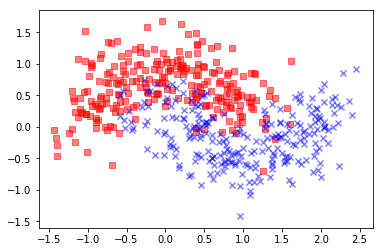

In [13]:
#import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.3, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=3)

plt.scatter(
    X[y == 0, 0], X[y == 0, 1], label='Class 0', c='r', marker='s', alpha=0.5)
plt.scatter(
    X[y == 1, 0], X[y == 1, 1], label='Class 1', c='b', marker='x', alpha=0.5)
plt.scatter(X_test[:, 0], X_test[:, 1], c='', marker='o', label='Class 1')
plt.show()

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', LogisticRegression(C=10, random_state=0)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(max_depth=3, random_state=0)]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', KNeighborsClassifier(n_neighbors=5)]])

In [14]:
from sklearn.model_selection import cross_val_score

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3], clf_labels):
  scores = cross_val_score(
      estimator=pipe, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('%s: %.3f (+/- %.3f)' % (label, scores.mean(), scores.std()))

[Individual]
LogisticRegression: 0.929 (+/- 0.029)
DecisionTree: 0.941 (+/- 0.023)
KNN: 0.948 (+/- 0.026)


In [15]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_score = None, (), -1
for a, b, c in list(
    itertools.permutations(range(0, 3))):  # try some weight combination
  clf = VotingClassifier(
      estimators=[('lr', pipe1), ('dt', pipe2), ('knn', pipe3)],
      voting='soft',
      weights=[a, b, c])
  scores = cross_val_score(
      estimator=clf, X=X_train, y=y_train, cv=10, scoring='roc_auc')
  print('%s: %.3f (+/- %.3f)' % ((a, b, c), scores.mean(), scores.std()))
  if best_score < scores.mean():
    best_vt, best_w, best_score = clf, (a, b, c), scores.mean()

print('\nBest %s: %.3f' % (best_w, best_score))

[Voting]
(0, 1, 2): 0.959 (+/- 0.021)
(0, 2, 1): 0.960 (+/- 0.019)
(1, 0, 2): 0.958 (+/- 0.023)
(1, 2, 0): 0.944 (+/- 0.025)
(2, 0, 1): 0.948 (+/- 0.023)
(2, 1, 0): 0.939 (+/- 0.025)

Best (0, 2, 1): 0.960


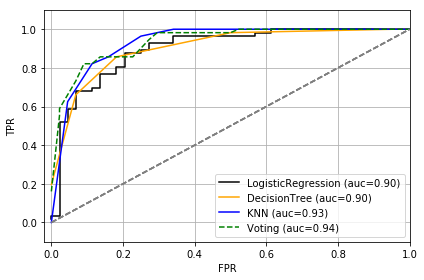

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

clf_labels = ['LogisticRegression', 'DecisionTree', 'KNN', 'Voting']
colors = ['black', 'orange', 'blue', 'green']
linestyles = ['-', '-', '-', '--']
for clf, label, clr, ls in zip([pipe1, pipe2, pipe3, best_vt], clf_labels,
                               colors, linestyles):
  # assume positive class is at dimension 2
  clf.fit(X_train, y_train)
  y_pred = clf.predict_proba(X_test)[:, 1]

  fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_pred)
  roc_auc = auc(x=fpr, y=tpr)

  plt.plot(
      fpr,
      tpr,
      color=clr,
      linestyle=ls,
      label='%s (auc=%0.2f)' % (label, roc_auc))
  plt.legend(loc='lower right')
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
  plt.xlim([-0.02, 1])
  plt.ylim([-0.1, 1.1])
  plt.grid()
  plt.xlabel('FPR')
  plt.ylabel('TPR')

plt.grid()
plt.tight_layout()
plt.savefig('./output/lab08-fig-vote-roc.png', dpi=300)
plt.show()

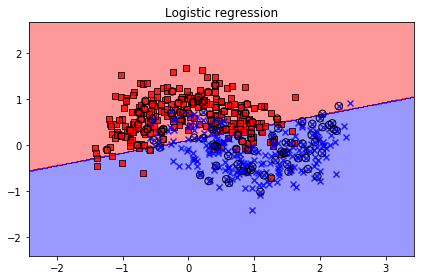

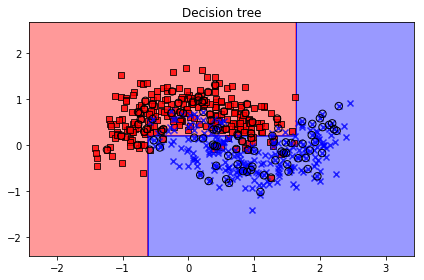

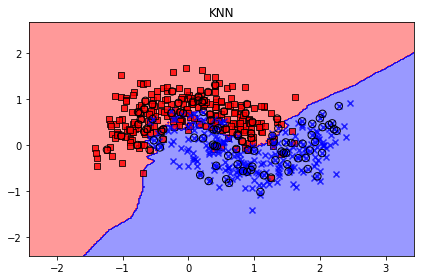

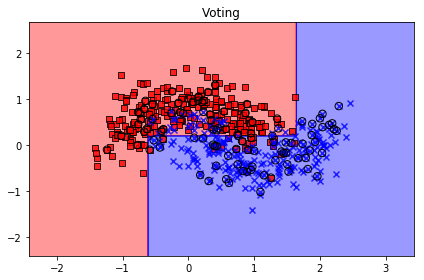

In [17]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe1,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Logistic regression')
plt.tight_layout()
plt.savefig('./output/lab08-fig-vote-logistic-regressio-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe2,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Decision tree')
plt.tight_layout()
plt.savefig('./output/lab08-fig-vote-decision-tree-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=pipe3,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('KNN')
plt.tight_layout()
plt.savefig('./output/lab08-fig-voting-knn-boundary.png', dpi=300)
plt.show()

plot_decision_regions(
    X=X_combined,
    y=y_combined,
    classifier=best_vt,
    test_idx=range(len(y_train), len(y_train) + len(y_test)))
plt.title('Voting')
plt.tight_layout()
plt.savefig('./output/lab08-fig-voting-boundary.png', dpi=300)
plt.show()
